# CelebA - Choosing subset

In the following, we choose a subset of the original CelebA dataset in order to decrease training time.

In choosing the subset, we take into account the ultimate goal of our project, to mitigate the effects of working with fewer data.

More specifically, using AttGAN, we decided to develop a "filter" capable of adding eyeglasses on a face, thus, we focus on choosing a subset that helps in doing so.


## Setting up the environment


### Importing modules


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


### Loading the dataset (annotations only)


In [2]:
data = pd.read_csv("data/list_attr_celeba.csv")
data.head() # display the first n=5 rows


,Image_Name,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [3]:
# Make attribute comparison table
indices = {
    "Complete": np.arange(len(data)),
    "Eyeglasses extended": np.load("data/chosen_indices_eyeglasses_smaller.npy"), 
    "Eyeglasses only": np.load("data/eyeglasses_only.npy"),
}

results = []
for k, v in indices.items():
    result = data.iloc[v].drop("Image_Name", axis="columns").sum() / len(v)
    result = result.to_frame().sort_values(by=0, ascending=False).head(10).reset_index()
    result = result.rename(columns={"index": "attribute", 0: "percentage"}).T.reset_index()
    result["dataset"] = k
    results.append(result.set_index(keys=["dataset", "index"]))
final = pd.concat(results, axis="rows")
final.columns += 1
style = final.T.style.format(precision=2, escape="latex").hide(names=True, axis="columns")
style.to_latex("results/dataset/att.tex", column_format="|c|lc|lc|lc|", hrules=True, clines="skip-last;index", multicol_align="c|")

## Choosing the subset

Because of the way AttGAN works (transferring knowledge from the reconstruction task to the generation task), we deemed appropriate to retain **all** the images labeled as having eyeglasses.

So we start from selecting those images and putting them aside.


In [4]:
eyeglasses_df = data[data['Eyeglasses'] == 1]
eyeglasses_paths = eyeglasses_df[['Image_Name']]
eyeglasses_count = len(eyeglasses_paths)
eyeglasses_paths.head() # display the first n=5 rows


,Image_Name
52,000053.jpg
92,000093.jpg
118,000119.jpg
143,000144.jpg
151,000152.jpg


Then, we (temporarily) remove those images from the dataset, and we subsample the dataset to match the desired number of images.

Here, we chose a 1-to-2 eyeglasses/no_eyeglasses ratio.

The reason we retain many images without eyeglasses is to favour generalization, such that the resulting filter will be able to work well with never-seen-before users.


In [5]:
no_eyeglasses_df = data[data['Eyeglasses'] == 0]
no_eyeglasses_paths = no_eyeglasses_df[['Image_Name']]
no_eyeglasses_count = eyeglasses_count*2
no_eyeglasses_subset = no_eyeglasses_paths.sample(no_eyeglasses_count, random_state=1) # random_state is set for reproducibility
no_eyeglasses_subset.head() # display the first n=5 rows



,Image_Name
168411,168412.jpg
96273,096274.jpg
155928,155929.jpg
46592,046593.jpg
86199,086200.jpg


In [6]:
print("The final number of image is", (no_eyeglasses_count+eyeglasses_count), "of which")
print(eyeglasses_count, "are with eyeglasses and")
print(no_eyeglasses_count, "are without eyeglasses")

The final number of image is 39579 of which
13193 are with eyeglasses and
26386 are without eyeglasses


Just to make sure, we finally compare the percentage distribution of annotations before and after subsampling (excluding the Eyeglasses attribute).


### Before subsampling


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,168471,135545,86770,149804,185965,159639,142718,147940,143746,159940,...,179245,97039,149572,126661,152027,180989,94741,165368,177336,38176
1,20935,53861,102636,39602,3441,29767,46688,41466,45660,29466,...,10161,92367,39834,62745,37379,8417,94665,24038,12070,151230


<AxesSubplot:>

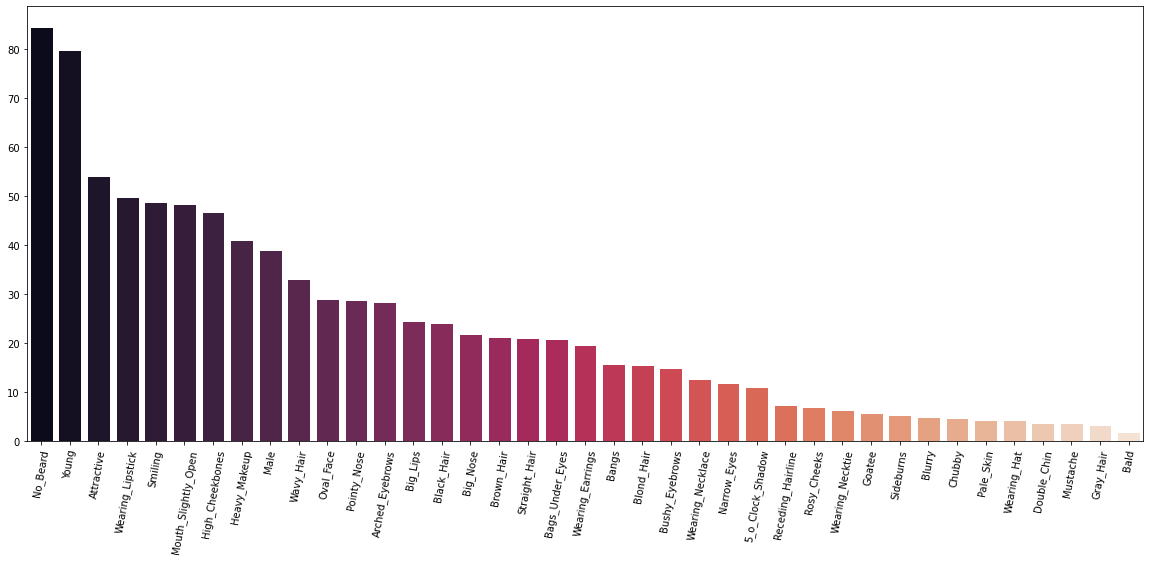

In [7]:
no_eyeglasses_df = no_eyeglasses_paths.join(data.set_index('Image_Name'), on='Image_Name')
no_eyeglasses_df = no_eyeglasses_df.drop(['Image_Name','Eyeglasses'], axis=1)
counts = no_eyeglasses_df.apply(pd.value_counts)
display(counts)
labeled_as_1 = counts.iloc[lambda x: x.index == 1]  # take only the row labeled as 1
descending_counts_pairs = sorted(
    zip(labeled_as_1.values.flatten(), labeled_as_1.columns), reverse=True
)   # sort annotations by descending frequency
x = [x for _, x in descending_counts_pairs] # unzip annotations
y = [y for y, _ in descending_counts_pairs] # unzip counts
y_percentage = [(count / len(no_eyeglasses_df)) * 100 for count in y]
plt.figure(figsize=(20, 8))
plt.xticks(rotation=80)
sns.set_style("whitegrid")
sns.barplot(x=x, y=y_percentage, palette="rocket")



### After subsampling


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,23474,18936,12016,20817,25930,22218,19845,20606,19989,22258,...,24976,13462,20897,17564,21128,25203,13150,23057,24700,5357
1,2912,7450,14370,5569,456,4168,6541,5780,6397,4128,...,1410,12924,5489,8822,5258,1183,13236,3329,1686,21029


<AxesSubplot:>

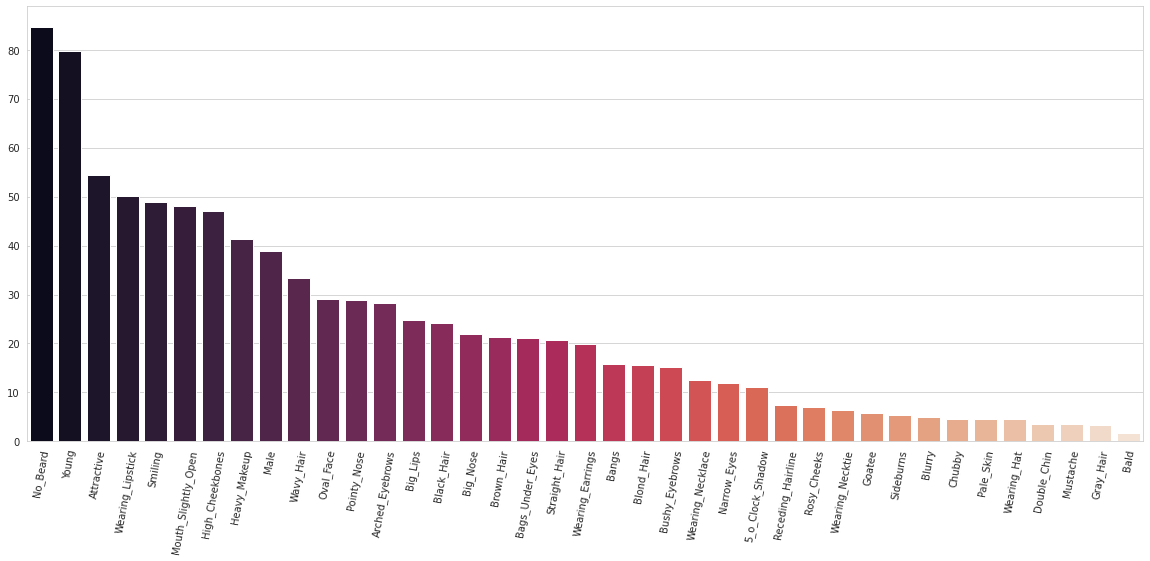

In [8]:
no_eyeglasses_subset_df = no_eyeglasses_subset.join(data.set_index('Image_Name'), on='Image_Name')
no_eyeglasses_subset_df = no_eyeglasses_subset_df.drop(['Image_Name','Eyeglasses'], axis=1)
counts = no_eyeglasses_subset_df.apply(pd.value_counts)
display(counts)
labeled_as_1 = counts.iloc[lambda x: x.index == 1]  # take only the row labeled as 1
descending_counts_pairs = sorted(
    zip(labeled_as_1.values.flatten(), labeled_as_1.columns), reverse=True
)   # sort annotations by descending frequency
x = [x for _, x in descending_counts_pairs] # unzip annotations
y = [y for y, _ in descending_counts_pairs] # unzip counts
y_percentage = [(count / len(no_eyeglasses_subset_df)) * 100 for count in y]
plt.figure(figsize=(20, 8))
plt.xticks(rotation=80)
sns.set_style("whitegrid")
sns.barplot(x=x, y=y_percentage, palette="rocket")

The plots look the same, but the number of occurrences (as shown by `display(counts)`) are different, which is exactly what we wanted.


## Putting everything together

We now glue back the images with eyeglasses and the subset of images without eyeglasses, and store their indices (nb: images' names are 1-indexed, but we need indices to be 0-indexed).


In [9]:
def index_from_filename(filename: str):
    without_jpg = filename[:-4]
    return int(without_jpg) - 1

chosen_images = pd.concat([eyeglasses_paths, no_eyeglasses_subset])
filenames = chosen_images["Image_Name"].to_list()
np_indices = np.asarray(list(map(index_from_filename, filenames)))
np.save(f"data/chosen_indices", np_indices)